<a href="https://colab.research.google.com/github/engrthony/Cryptocurrency/blob/main/Machine_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libraries and Data

In [ ]:
import pandas as pd
import numpy as np
from google.colab import drive
drive.mount('/content/drive')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.preprocessing import MinMaxScaler

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, VotingRegressor

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras import Input
from tensorflow.keras import layers, regularizers

Mounted at /content/drive


In [ ]:
# extracted from c
data = pd.read_csv('/content/drive/Shareddrives/Machine Learning/BTC-USD.csv')
df = pd.DataFrame(data[['Date','Price']]).dropna()
df.set_index('Date', inplace=True)
df

,Price
Date,
07/18/10,0.1
07/19/10,0.1
07/20/10,0.1
07/21/10,0.1
07/22/10,0.1
...,...
04/21/25,87516.0
04/22/25,93441.9
04/23/25,93697.7


# Feature Engineering

In [ ]:
ema_periods = [5, 10, 20, 50, 100, 200]
for period in ema_periods:
    df[f'EMA_{period}'] = df["Price"].ewm(span=period, adjust=False).mean()

In [ ]:
# RSI Calculation Function
def compute_rsi(series, period=14):
    delta = series.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))

df['RSI_14'] = compute_rsi(df['Price'])

In [ ]:
df.dropna(inplace=True)

In [ ]:
features = df[['EMA_5', 'EMA_10', 'EMA_20', 'EMA_50', 'EMA_100', 'EMA_200', 'RSI_14']]  # Modify based on dataset
target = df['Price']

X = features
y = target

In [ ]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(X)

In [ ]:
# --- Create Sequences ---
def create_sequences(data, seq_length=60):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length][0])  # Only use the first feature (Price)
    return np.array(X), np.array(y)

SEQ_LEN = 60
X, y = create_sequences(scaled_data, SEQ_LEN)

# --- Train-Test Split ---
split_index = int(0.8 * len(X))
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

# Attention-based LSTM

In [ ]:
# --- Define Attention Layer ---
class Attention(tf.keras.layers.Layer):
    def __init__(self):
        super(Attention, self).__init__()
        self.W = tf.keras.layers.Dense(1)

    def call(self, inputs):
        score = self.W(inputs)  # (batch_size, time_steps, 1)
        weights = tf.nn.softmax(score, axis=1)
        context = tf.reduce_sum(inputs * weights, axis=1)
        return context


In [ ]:
# --- Build Model ---
def build_model_1(input_shape):
    inputs = layers.Input(shape=input_shape)
    x = layers.LSTM(64, return_sequences=True)(inputs)
    x = layers.Dropout(0.3)(x)
    x = layers.LSTM(32, return_sequences=True)(x)
    x = Attention()(x)
    x = layers.Dense(32, activation='relu')(x)
    outputs = layers.Dense(1)(x)
    model = models.Model(inputs, outputs)
    model.compile(optimizer='adam', loss='mse')
    return model

model_1 = build_model_1((SEQ_LEN, features.shape[1]))
model_1.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 60, 7)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 60, 64)         │        18,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 60, 32)         │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ attention (Attention)           │ (None, 32)             │            33 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,970 (124.88 KB)

 Trainable params: 31,970 (124.88 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# --- Train the Model ---
early_stopping = tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
history = model_1.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.1,
                      callbacks=[early_stopping], verbose=1)


Epoch 1/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 13s 58ms/step - loss: 0.0011 - val_loss: 0.0225
Epoch 2/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 11s 63ms/step - loss: 2.4243e-04 - val_loss: 0.0171
Epoch 3/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 11s 69ms/step - loss: 2.2626e-04 - val_loss: 0.0198
Epoch 4/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 9s 55ms/step - loss: 1.5286e-04 - val_loss: 0.0136
Epoch 5/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 11s 57ms/step - loss: 1.7112e-04 - val_loss: 0.0113
Epoch 6/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 8s 68ms/step - loss: 1.2308e-04 - val_loss: 0.0171
Epoch 7/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 9s 56ms/step - loss: 1.3154e-04 - val_loss: 0.0073
Epoch 8/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 11s 59ms/step - loss: 1.2568e-04 - val_loss: 0.0092
Epoch 9/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 10s 59ms/step - loss: 1.1357e-04 - val_loss: 0.0213
Epoch 10/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 11s 69ms/step - loss: 1.5078e-04 - val_loss: 0.0242
Epoch 11/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 6s 55ms/step - loss: 1.2078e-04 - val_loss: 0

In [ ]:
# --- Predict ---
y_pred_1 = model_1.predict(X_test)


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step


In [ ]:
# --- Shape Check & Alignment ---
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of y_test: {y_test.shape}")
print(f"Shape of y_pred_1: {y_pred_1.shape}")

# Truncate if shape mismatch
min_len = min(y_test.shape[0], y_pred_1.shape[0])
y_test = y_test[:min_len]
y_pred_1 = y_pred_1[:min_len]

# --- Inverse Scaling ---
y_test_reshaped = y_test.reshape(-1, 1)
num_features = X_test.shape[-1]

y_pred_1_for_inverse = np.repeat(y_pred_1, num_features, axis=1)
y_test_for_inverse = np.repeat(y_test_reshaped, num_features, axis=1)

y_pred_rescaled_1 = scaler.inverse_transform(y_pred_1_for_inverse)[:, 0]
y_test_rescaled_1 = scaler.inverse_transform(y_test_for_inverse)[:, 0]

# Final Check
assert y_test_rescaled_1.shape == y_pred_rescaled_1.shape, \
    f"Shape mismatch! y_test: {y_test_rescaled_1.shape}, y_pred: {y_pred_rescaled_1.shape}"


Shape of X_test: (1046, 60, 7)
Shape of y_test: (1046,)
Shape of y_pred_1: (1046, 1)


In [ ]:
# --- Evaluation ---
rmse_1 = np.sqrt(mean_squared_error(y_test_rescaled_1, y_pred_rescaled_1))
mae_1 = mean_absolute_error(y_test_rescaled_1, y_pred_rescaled_1)
r2_1 = r2_score(y_test_rescaled_1, y_pred_rescaled_1)

print(f"✅ RMSE: {rmse_1:.2f}")
print(f"✅ MAE: {mae_1:.2f}")
print(f"✅ R²: {r2_1:.2f}")


✅ RMSE: 15322.84
✅ MAE: 11664.49
✅ R²: 0.66


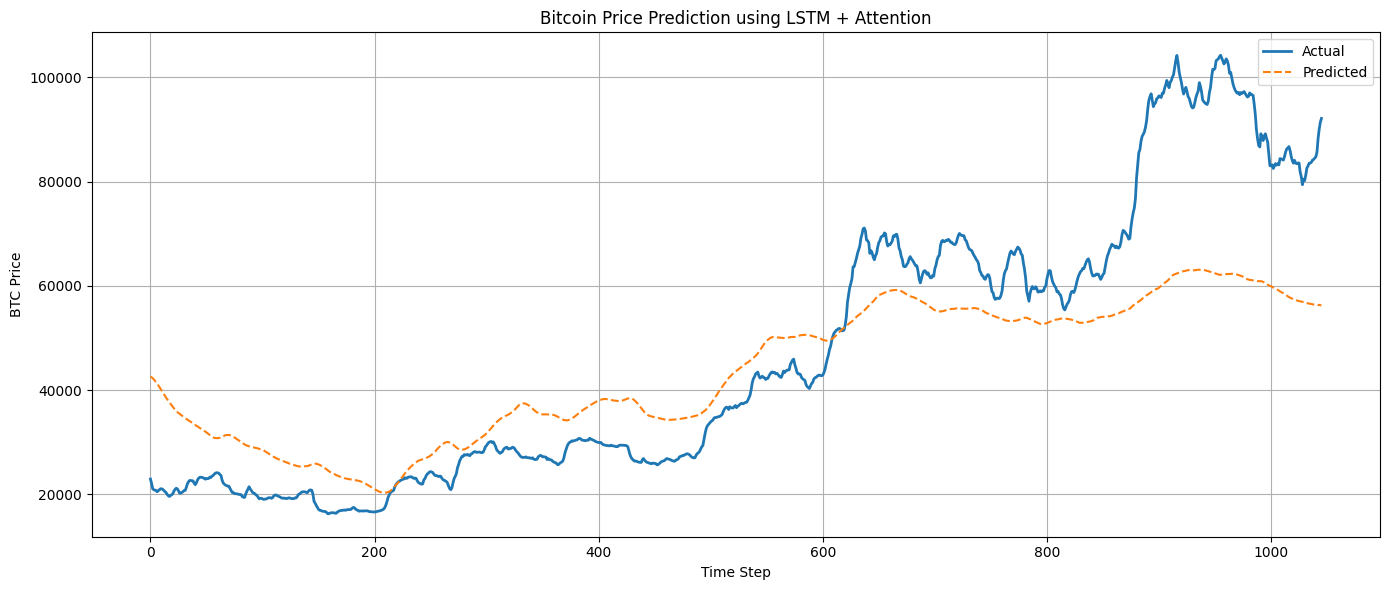

In [ ]:
# --- Plot Results ---
plt.figure(figsize=(14, 6))
plt.plot(y_test_rescaled_1, label='Actual', linewidth=2)
plt.plot(y_pred_rescaled_1, label='Predicted', linestyle='--')
plt.title("Bitcoin Price Prediction using LSTM + Attention")
plt.xlabel("Time Step")
plt.ylabel("BTC Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Ensemble ML Method

In [ ]:

# Define Ensemble Models
rf = RandomForestRegressor(n_estimators=100, random_state=42)
gb = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=42)

ensemble = VotingRegressor(estimators=[
    ('rf', rf),
    ('gb', gb)
])

In [ ]:
# Train Ensemble Model
ensemble.fit(X_train.reshape(X_train.shape[0], -1), y_train)

VotingRegressor(estimators=[('rf', RandomForestRegressor(random_state=42)),
                            ('gb', GradientBoostingRegressor(random_state=42))])

In [ ]:
# Predict on Test Data
y_pred_2 = ensemble.predict(X_test.reshape(X_test.shape[0], -1))

In [ ]:
# Evaluation Metrics
rmse_2 = np.sqrt(mean_squared_error(y_test, y_pred_2))
mae_2 = mean_absolute_error(y_test, y_pred_2)
r2_2 = r2_score(y_test, y_pred_2)

print(f"RMSE: {rmse_2:.4f}")
print(f"MAE: {mae_2:.4f}")
print(f"R2 Score: {r2_2:.4f}")

RMSE: 0.1231
MAE: 0.0646
R2 Score: 0.7617


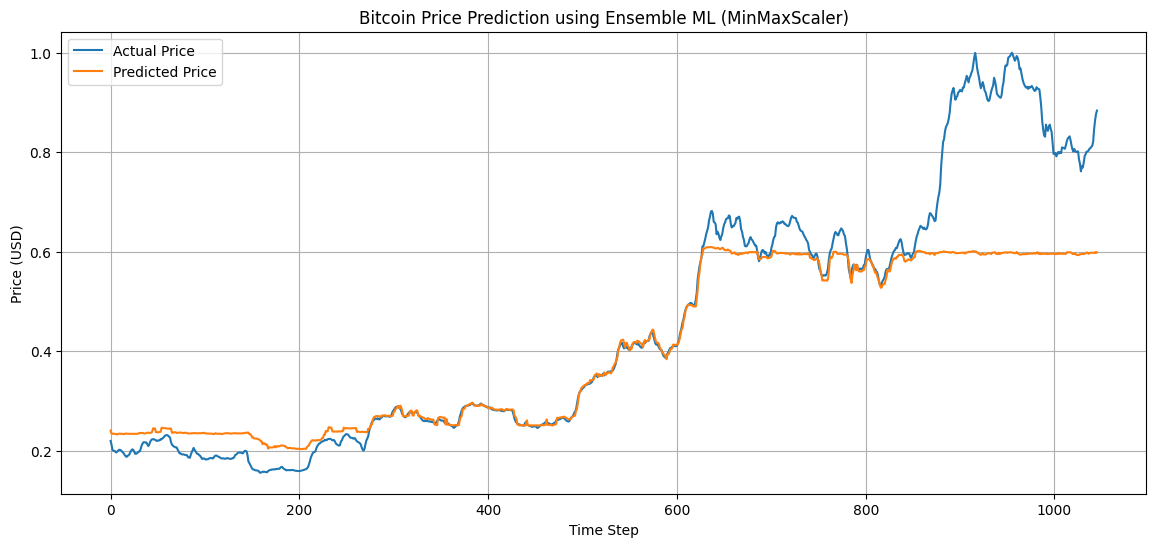

In [ ]:
# Plotting Predictions vs Actual
plt.figure(figsize=(14, 6))
# Use a range of integers as the x-axis since y_test is a numpy array
# Removed the second index as y_test is 1-dimensional
plt.plot(np.arange(len(y_test)), y_test, label='Actual Price')
plt.plot(np.arange(len(y_pred_2)), y_pred_2, label='Predicted Price')
plt.title("Bitcoin Price Prediction using Ensemble ML (MinMaxScaler)")
plt.xlabel("Time Step") # Changed xlabel to reflect using time steps
plt.ylabel("Price (USD)")
plt.legend()
plt.grid(True)
plt.show()

#  Neural Networks

In [ ]:
#Build the model
neural_model = Sequential([
    Input(shape=(SEQ_LEN, 7)),
    LSTM(64, return_sequences=True),
    Dropout(0.2),
    LSTM(64),
    Dropout(0.2),
    Dense(1)
])

neural_model.compile(optimizer='adam', loss='mse')
neural_model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.1)


Epoch 1/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 11s 66ms/step - loss: 0.0020 - val_loss: 0.0071
Epoch 2/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 9s 60ms/step - loss: 2.5794e-04 - val_loss: 0.0045
Epoch 3/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 12s 73ms/step - loss: 1.9322e-04 - val_loss: 0.0018
Epoch 4/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 11s 77ms/step - loss: 1.7785e-04 - val_loss: 0.0010
Epoch 5/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 7s 62ms/step - loss: 2.4318e-04 - val_loss: 0.0031
Epoch 6/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 9s 78ms/step - loss: 1.5657e-04 - val_loss: 0.0051
Epoch 7/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 10s 78ms/step - loss: 1.2701e-04 - val_loss: 0.0021
Epoch 8/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 8s 61ms/step - loss: 1.5675e-04 - val_loss: 7.4222e-04
Epoch 9/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 9s 77ms/step - loss: 1.1970e-04 - val_loss: 0.0014
Epoch 10/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 9s 65ms/step - loss: 1.5317e-04 - val_loss: 4.4300e-04
Epoch 11/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 10s 61ms/step - loss: 8.2913e-05 - val_l

In [ ]:
# Predict & Evaluate
y_pred_neural = neural_model.predict(X_test) # Keep as 2D (num_samples, 1)


33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step


In [ ]:
# Inverse transform
# y_pred_neural has shape (num_samples, 1). We need to repeat it to match the
# number of features the scaler was fitted on (7 features).
y_pred_neural_rescaled = scaler.inverse_transform(np.repeat(y_pred_neural, X_test.shape[-1], axis=1))[:, 0]

# y_test is currently 1D. We need to reshape it to 2D (num_samples, 1)
# and then repeat it across the original number of features (7) before inverse transforming.
y_test_reshaped_for_inverse = y_test.reshape(-1, 1)
y_test_for_inverse = np.repeat(y_test_reshaped_for_inverse, X_test.shape[-1], axis=1)
y_test_rescaled = scaler.inverse_transform(y_test_for_inverse)[:, 0]

In [ ]:
# Calculate metrics on the rescaled data
rmse_3 = np.sqrt(mean_squared_error(y_test_rescaled, y_pred_neural_rescaled))
mae_3 = mean_absolute_error(y_test_rescaled, y_pred_neural_rescaled)
r2_3 = r2_score(y_test_rescaled, y_pred_neural_rescaled)

print("RMSE:", rmse_3)
print("MAE:", mae_3)
print("R2 Score:", r2_3)

RMSE: 3989.2967129286067
MAE: 2455.327949318749
R2 Score: 0.9769546873168602


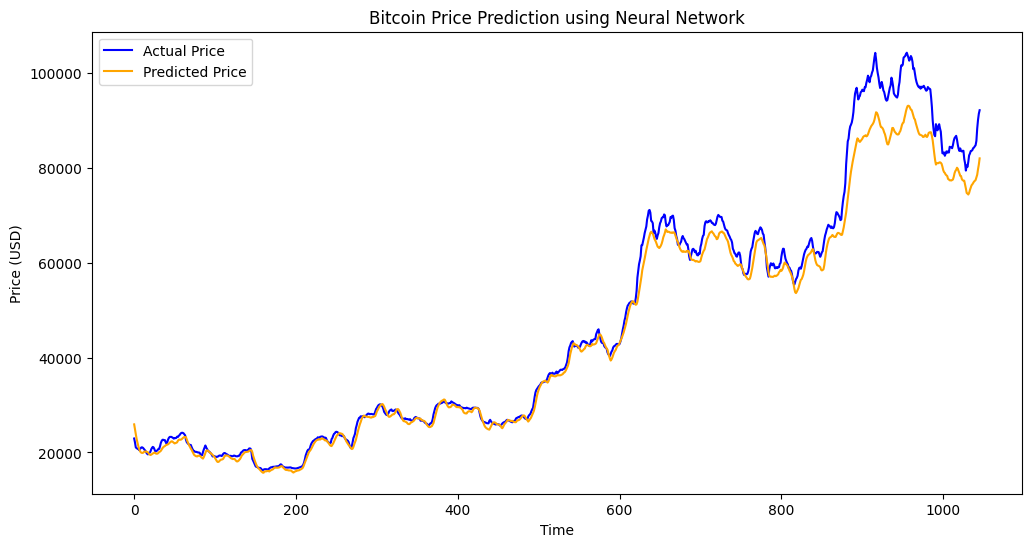

In [ ]:
# Plotting the results of the Neural Network model
plt.figure(figsize=(12, 6))
# Use the correctly rescaled variables for plotting
plt.plot(y_test_rescaled, label='Actual Price', color='blue')
plt.plot(y_pred_neural_rescaled, label='Predicted Price', color='orange')
plt.title('Bitcoin Price Prediction using Neural Network')
plt.xlabel('Time')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()

# Bayesian Attention LSTM with Uncertainty

In [ ]:
# === Data Augmentation Functions ===

def bootstrap(arr, n_samples):
    # Ensure arr is a NumPy array
    arr = np.array(arr)
    idxs = np.random.choice(np.arange(len(arr)), size=n_samples, replace=True)
    # Use NumPy integer indexing, which selects rows
    return arr[idxs]

def time_warp(arr, sigma=0.2):
    # Ensure arr is a NumPy array
    arr = np.array(arr)
    warped = arr.copy()
    warp_strength = 1 + np.random.normal(0, sigma)

    # Interpolation needs to be done along the time steps (axis 0) for each feature (axis 1)
    # The original time steps are just the indices 0 to len(arr)-1
    original_steps = np.arange(len(arr))

    # Create new time steps based on warp strength
    new_steps = np.arange(0, len(arr), warp_strength)

    warped_arr = np.zeros((len(new_steps), arr.shape[1]))

    for i in range(arr.shape[1]): # Iterate over features
        warped_arr[:, i] = np.interp(new_steps, original_steps, arr[:, i])

    # Adjust size if necessary
    if warped_arr.shape[0] < arr.shape[0]:
        # Pad with zeros if warped is shorter
        padding = np.zeros((arr.shape[0] - warped_arr.shape[0], arr.shape[1]))
        warped_arr = np.vstack([warped_arr, padding])
    elif warped_arr.shape[0] > arr.shape[0]:
        # Truncate if warped is longer
        warped_arr = warped_arr[:arr.shape[0]]

    return warped_arr

In [ ]:
# === Create Sequences exclusive for Bayesian ===
SEQ_LEN = 60

import random # Import the random module here


def b_create_sequences(data, seq_len):
    Xb, yb = [], []
    for i in range(len(data) - seq_len):
        seq = data[i:i+seq_len]
        # Augment 50% of sequences
        if random.random() < 0.5:
            if random.random() < 0.5:
                seq = bootstrap(seq, seq_len)
            else:
                seq = time_warp(seq)
        Xb.append(seq) # Changed X to Xb
        yb.append(data[i+seq_len][0])  # Closing Price
    return np.array(Xb), np.array(yb) # Changed X and y to Xb and yb

Xb, yb = b_create_sequences(scaled_data, SEQ_LEN)
split = int(0.8 * len(Xb))
Xb_train, Xb_test = Xb[:split], Xb[split:]
yb_train, yb_test = yb[:split], yb[split:]


In [ ]:
from tensorflow.keras.regularizers import l2

# Define Attention Layer and Build Model
class Attention(tf.keras.layers.Layer):
    def __init__(self):
        super().__init__()

    def call(self, inputs):
        score = tf.nn.softmax(tf.reduce_sum(inputs, axis=-1), axis=-1)
        context = tf.reduce_sum(inputs * tf.expand_dims(score, -1), axis=1)
        return context

# === Monte Carlo Dropout ===
class MCDropout(tf.keras.layers.Dropout):
    def call(self, inputs, training=None):
        return super().call(inputs, training=True)

def build_model(input_shape):
    inputs = layers.Input(shape=input_shape)
    x = layers.LSTM(64, return_sequences=True,
                    kernel_regularizer=l2(1e-4))(inputs)
    x = MCDropout(0.2)(x)
    x = layers.LSTM(64, return_sequences=True)(x)
    x = MCDropout(0.2)(x)
    x = Attention()(x)
    x = layers.Dense(32, activation='relu')(x)
    x = MCDropout(0.2)(x)
    output = layers.Dense(1)(x)
    model = models.Model(inputs, output)
    model.compile(optimizer='adam', loss='mse')
    return model

model_bayes = build_model((SEQ_LEN, 7)) # Update based on the Number of Features
model_bayes.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 60, 7)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_8 (LSTM)                   │ (None, 60, 64)         │        18,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mc_dropout_6 (MCDropout)        │ (None, 60, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_9 (LSTM)                   │ (None, 60, 64)         │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mc_dropout_7 (MCDropout)        │ (None, 60, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ attention_3 (Attention)         │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mc_dropout_8 (MCDropout)        │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 53,569 (209.25 KB)

 Trainable params: 53,569 (209.25 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
#Train the Model
history = model_bayes.fit(Xb, yb, epochs=20, batch_size=32, validation_split=0.2, callbacks=[
    tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
])

Epoch 1/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 15s 77ms/step - loss: 0.0097 - val_loss: 0.0252
Epoch 2/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 11s 84ms/step - loss: 0.0019 - val_loss: 0.0256
Epoch 3/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 19s 70ms/step - loss: 0.0016 - val_loss: 0.0377
Epoch 4/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 11s 80ms/step - loss: 0.0016 - val_loss: 0.0258
Epoch 5/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 21s 85ms/step - loss: 0.0016 - val_loss: 0.0357
Epoch 6/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 9s 68ms/step - loss: 0.0015 - val_loss: 0.0293


In [ ]:
# === Predict with Uncertainty (MC Sampling) ===
def predict_with_uncertainty(model_bayes, Xb, n_iter=100):
    preds = [model_bayes(Xb, training=True).numpy().flatten() for _ in range(n_iter)]
    preds = np.array(preds)
    mean = preds.mean(axis=0)
    std = preds.std(axis=0)
    return mean, std

yb_pred_mean, yb_pred_std = predict_with_uncertainty(model_bayes, Xb_test)


In [ ]:
# === Evaluate ===
rmse_4 = np.sqrt(mean_squared_error(yb_test, yb_pred_mean))
r2_4 = r2_score(yb_test, yb_pred_mean)
mae_4 = mean_absolute_error(yb_test, yb_pred_mean)
print("RMSE:", rmse_4)
print("MAE:", mae_4)
print("R2 Score:", r2_4)

RMSE: 0.14398875401845002
MAE: 0.09453575979023657
R2 Score: 0.6737984073986116


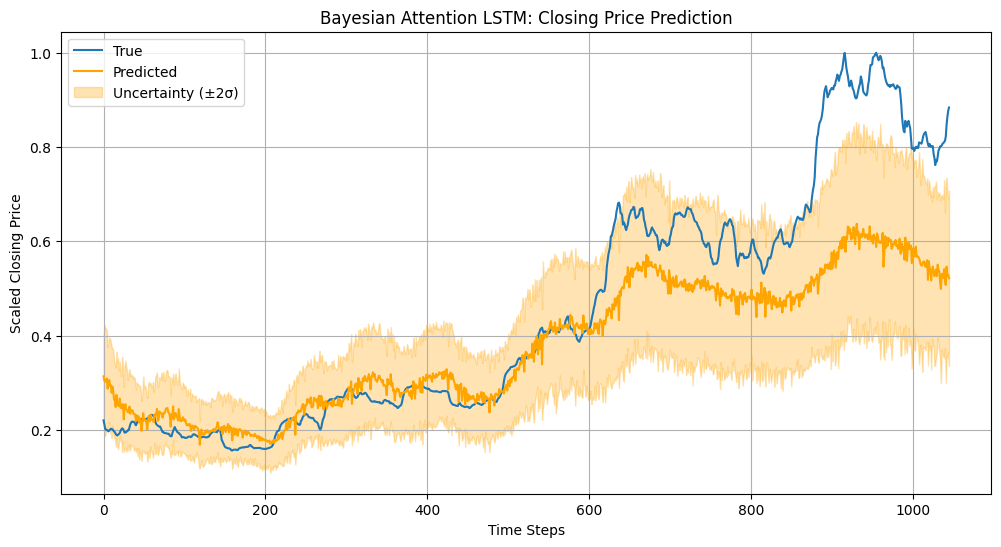

In [ ]:
# Plot results
plt.figure(figsize=(12, 6))
plt.plot(yb_test, label='True')
plt.plot(yb_pred_mean, label='Predicted', color='orange')
plt.fill_between(np.arange(len(yb_pred_mean)),
                 yb_pred_mean - 2*yb_pred_std,
                 yb_pred_mean + 2*yb_pred_std,
                 color='orange', alpha=0.3, label='Uncertainty (±2σ)')
plt.title("Bitcoin Price Prediction using Bayesian Attention LSTM")
plt.xlabel("Time Steps")
plt.ylabel("Scaled Closing Price")
plt.legend()
plt.grid(True)